# 4. Explainable AI (XAI)

In [64]:
# -------------------------- Standard Libraries --------------------------
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis

# -------------------------- Model Interpretation Libraries --------------------------
import shap  # SHAP for model explainability
import lime  # LIME for local interpretable model-agnostic explanations
from lime.lime_tabular import LimeTabularExplainer  # LIME for tabular data
from IPython.display import display, HTML

# -------------------------- Explanation Libraries --------------------------
import joblib  # For saving/loading models
import matplotlib.pyplot as plt  # For visualizing results
from alibi.explainers import AnchorTabular  # Anchor for model interpretation

# -------------------------- Additional Considerations --------------------------
# Ensure the necessary libraries are installed
# pip install shap lime alibi


In [65]:
# -------------------------- Load Data --------------------------
# Define file paths
X_train_path = os.path.join("feature_selection", "X_train_selected.csv")
X_test_path = os.path.join("feature_selection", "X_test_selected.csv")
cid_path = os.path.join("split_data", "customer_test.csv")  # Path to customer test data (customer IDs)

# Try to load datasets and handle errors
try:
    X_train_selected = pd.read_csv(X_train_path)
    X_test_selected = pd.read_csv(X_test_path)
    customer_test = pd.read_csv(cid_path)  # Load customer test data (without index column)

    print("Datasets loaded successfully!")

except FileNotFoundError as e:
    print(f"Error loading files: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Datasets loaded successfully!


### SHAP

In [ ]:
import shap
import pickle

# Load the trained model
model_path = "best_svm_model.pkl"
with open(model_path, "rb") as file:
    model = pickle.load(file)

# Print the JS visualization code to the notebook
shap.initjs()

# Summarize the background data using shap.sample
K = 50  # Reduce the number of samples further for faster execution
X_train_summary = shap.sample(X_train_selected, K)

# explain all the predictions in the test set
svc_explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)
shap_values = svc_explainer.shap_values(X_test_selected, nsamples=100)

# Save  to a .pkl file
with open("svc_explainer.pkl", "wb") as f:
    pickle.dump(svc_explainer, f)

# Save  to a .pkl file
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# this is multiclass so we only visualize the contributions to first class (hence index 0)
shap.force_plot(svc_explainer.expected_value[0], shap_values[..., 0], X_test_selected)

  0%|          | 0/1409 [00:00<?, ?it/s]

Local explanations, on the other hand, zoom in on individual predictions. They help you answer the question: “Why did the model make this specific prediction for this specific sample?” This is incredibly useful when you need to understand or justify why the model made a particular decision for one instance — think about individual patients in healthcare or individual loan applications in finance.

In [67]:
# Check shapes for consistency
print(shap_values)

[[[ 0.05873052 -0.05873052]
  [ 0.12181117 -0.12181117]
  [ 0.022851   -0.022851  ]
  ...
  [ 0.04893337 -0.04893337]
  [ 0.03071448 -0.03071448]
  [ 0.          0.        ]]

 [[-0.00834449  0.00834449]
  [-0.18797008  0.18797008]
  [ 0.          0.        ]
  ...
  [ 0.04838048 -0.04838048]
  [-0.0031996   0.0031996 ]
  [-0.04662427  0.04662427]]

 [[ 0.0207525  -0.0207525 ]
  [ 0.11934318 -0.11934318]
  [ 0.0675096  -0.0675096 ]
  ...
  [ 0.02472662 -0.02472662]
  [ 0.02533223 -0.02533223]
  [ 0.07697243 -0.07697243]]

 ...

 [[-0.0364847   0.0364847 ]
  [-0.07723246  0.07723246]
  [ 0.05741677 -0.05741677]
  ...
  [-0.01301334  0.01301334]
  [-0.03592748  0.03592748]
  [-0.0102194   0.0102194 ]]

 [[ 0.0171674  -0.0171674 ]
  [ 0.15520519 -0.15520519]
  [ 0.02160123 -0.02160123]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.01922202 -0.01922202]
  [ 0.16988064 -0.16988064]
  [ 0.03333932 -0.03333932]
  ...
  [ 0.          0.      

#### SHAP summary plot

SHAP values for class 0 (2D array) shape: (1409, 10)
SHAP values for class 0 for instance 1 (first row):
[-0.05873052 -0.12181117 -0.022851    0.         -0.15282984  0.
  0.         -0.04893337 -0.03071448  0.        ]


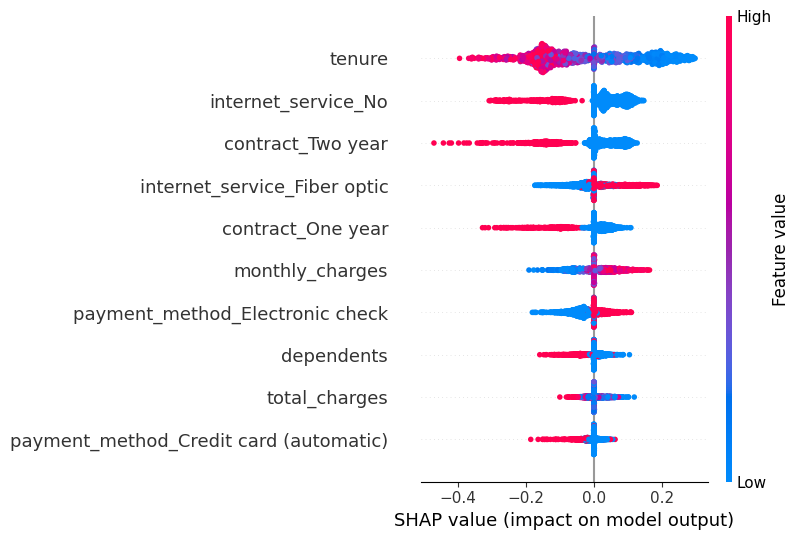

In [68]:
# Extract SHAP values for class 0 (first class) across all instances and features
# Here, shap_values[0] corresponds to the SHAP values for class 0 (first class)
shap_values_class_1 = shap_values[:, :, 1]  # This is a 2D array with shape [instances, features]

# Save LabelEncoders to a .pkl file
with open("shap_values_class_1.pkl", "wb") as f:
    pickle.dump(shap_values_class_1, f)

# Print the shape of the 2D array (SHAP values for class 0)
print(f"SHAP values for class 0 (2D array) shape: {shap_values_class_1.shape}")

# Optionally, print SHAP values for the first instance and class 0
print("SHAP values for class 0 for instance 1 (first row):")
print(shap_values_class_1[0, :])

# Visualizing using a summary plot for class 1
shap.summary_plot(shap_values_class_1, X_test_selected)

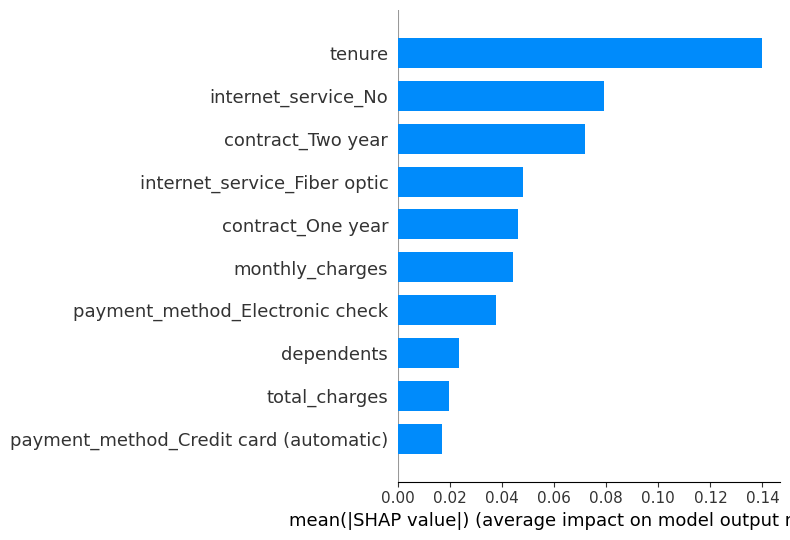

In [69]:
# Visualizing using a summary plot for class 0
shap.summary_plot(shap_values_class_1, X_test_selected, plot_type='bar')

#### SHAP waterfall plot

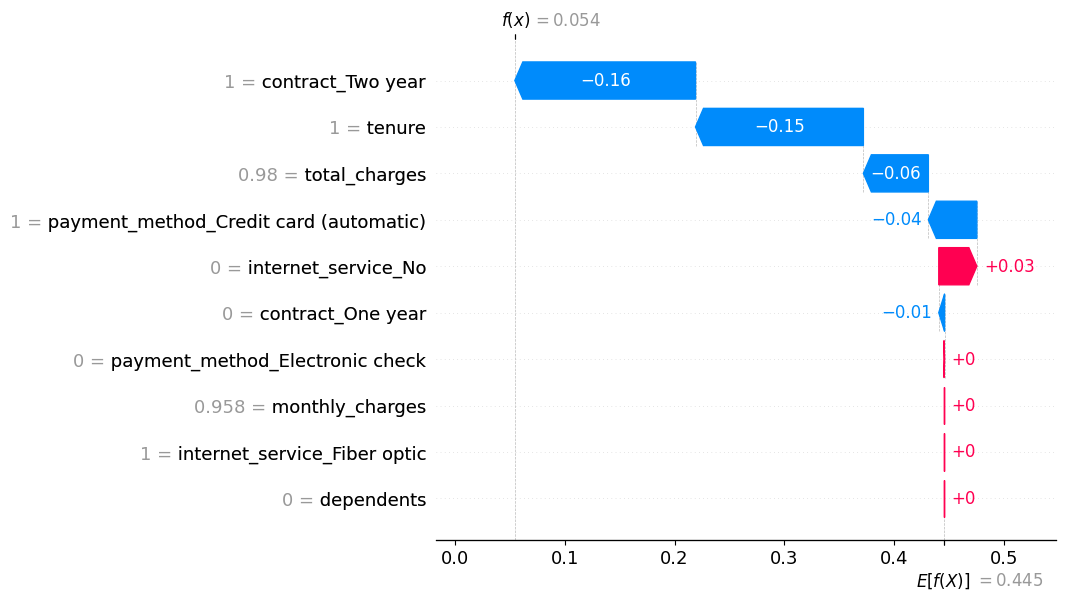

In [70]:
# Select the SHAP values for class 1 (you can change to class 0 if needed)
shap_values_class_1 = shap_values[:, :, 1]   # Extract SHAP values for class 1

# Visualizing the Waterfall plot for the first instance (instance 1)
shap.plots.waterfall(shap.Explanation(values=shap_values_class_1[400],  # SHAP values for class 1, instance 1
                                      base_values=svc_explainer.expected_value[1],  # Expected value for class 1
                                      data=X_test_selected.iloc[400, :],  # The features for the first instance
                                      feature_names=X_test_selected.columns))  # Feature names


#### SHAP bar plot

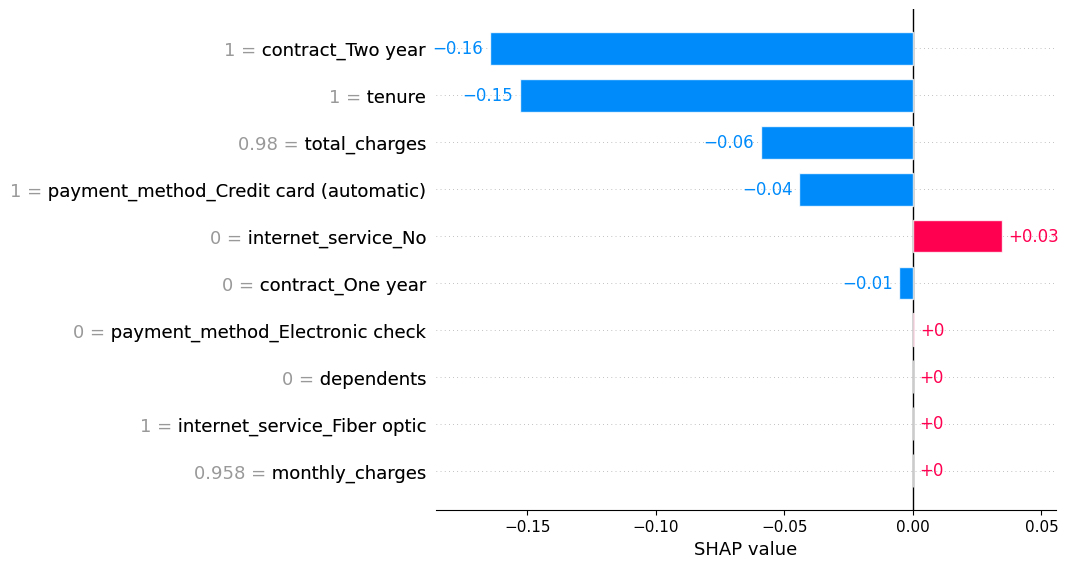

In [71]:
# Select the SHAP values for class 1 (you can change to class 0 if needed)
shap_values_class_1 = shap_values[:, :, 1]   # Extract SHAP values for class 1

# Visualizing the Waterfall plot for the first instance (instance 1)
shap.plots.bar(shap.Explanation(values=shap_values_class_1[400],  # SHAP values for class 1, instance 1
                                      base_values=svc_explainer.expected_value[1],  # Expected value for class 1
                                      data=X_test_selected.iloc[400, :],  # The features for the first instance
                                      feature_names=X_test_selected.columns))  # Feature names


#### SHAP force plot

In [72]:
# 3. Force Plot for the first instance (instance 1)
shap.plots.force(shap.Explanation(values=shap_values_class_1[400],  # SHAP values for class 1, instance 1
                                  base_values=svc_explainer.expected_value[1],  # Expected value for class 1
                                  data=X_test_selected.iloc[400, :],  # The features for the first instance
                                  feature_names=X_test_selected.columns))  # Feature names

#### SHAP dependence plot

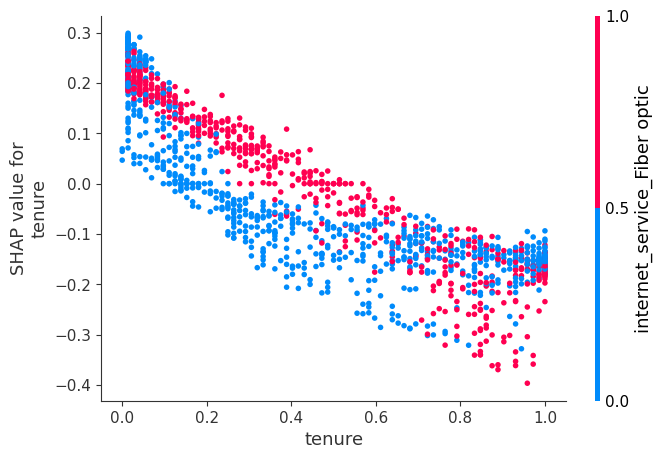

In [73]:
# SHAP Dependence Plot for a specific feature
shap.dependence_plot(
    "tenure",  # Replace with the actual feature name you want to visualize
    shap_values_class_1,  # SHAP values for class 1
    X_test_selected  # The features for all instances
)


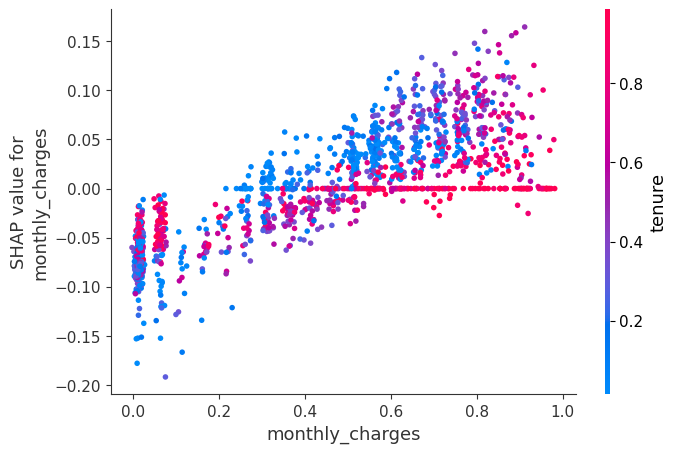

In [74]:
# SHAP Dependence Plot for a specific feature
shap.dependence_plot(
    "monthly_charges",  # Replace with the actual feature name you want to visualize
    shap_values_class_1,  # SHAP values for class 1
    X_test_selected  # The features for all instances
)


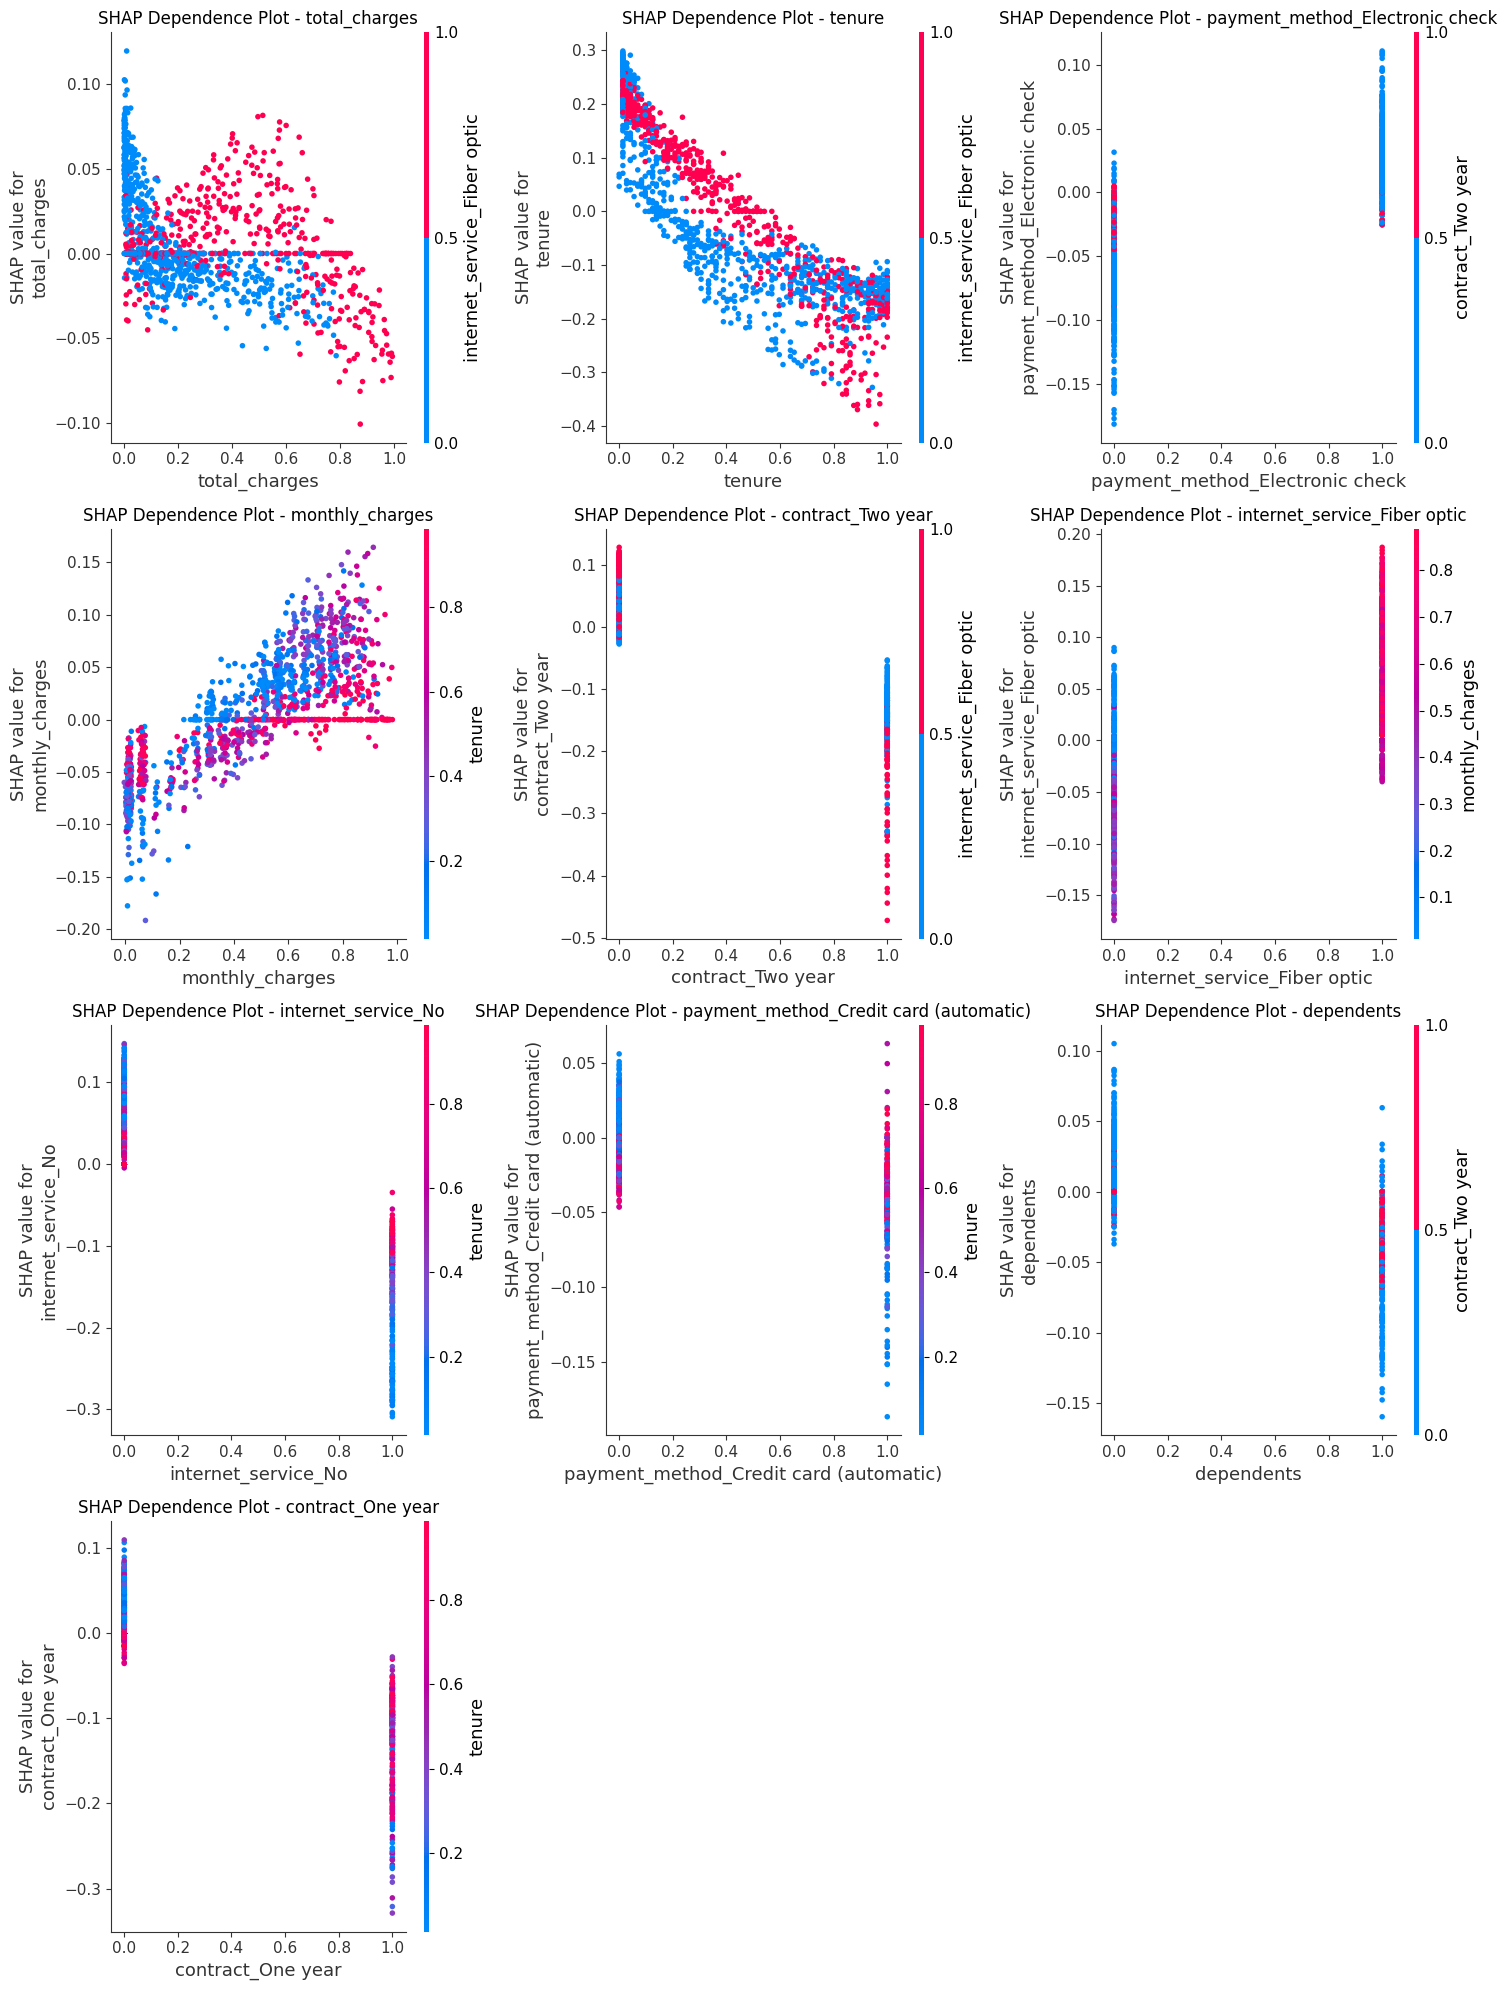

In [75]:
import matplotlib.pyplot as plt
import shap

# Define the number of rows and columns for the grid
n_features = len(X_test_selected.columns)
n_cols = 3  # Set the number of columns for the grid
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  # Calculate the number of rows needed

# Create a figure to hold the subplots
fig = plt.figure(figsize=(15, n_rows * 5))  # Adjust the figure size accordingly

# Loop through all the features and plot each one in a separate subplot
for i, feature in enumerate(X_test_selected.columns):
    # Add a subplot to the figure
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    
    # Create the SHAP Dependence Plot for the current feature
    shap.dependence_plot(feature, shap_values[:,:, 1], X_test_selected, ax=ax, show=False)
    
    # Set the title for each subplot
    ax.set_title(f"SHAP Dependence Plot - {feature}")

# Adjust layout
plt.tight_layout()
plt.show()


### LIME

In [91]:

import lime
import lime.lime_tabular
import numpy as np

In [98]:

# Assuming lime_explainer is already defined as you mentioned
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_selected.values, feature_names=X_train_selected.columns, class_names=[0, 1], discretize_continuous=True)



In [99]:

# Select a specific instance for explanation
instance_idx = 1
exp = lime_explainer.explain_instance(X_test_selected.loc[instance_idx].values, model.predict_proba)
# Visualize the explanation
# print("The column analysis of ",X_test_ohe_outlier.iloc[instance_idx])
exp.show_in_notebook(show_table=True, show_all=False)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [79]:
exp.as_list()

[('internet_service_No <= 0.00', 0.30977677029824996),
 ('contract_Two year <= 0.00', 0.29082401037724426),
 ('payment_method_Electronic check <= 0.00', -0.2902033868984877),
 ('0.06 < tenure <= 0.29', 0.16755857054574017),
 ('payment_method_Credit card (automatic) > 0.00', 0.13999976850228307),
 ('dependents <= 0.00', 0.11663292623319481),
 ('0.00 < internet_service_Fiber optic <= 1.00', 0.09253164118402062),
 ('monthly_charges > 0.71', 0.06705451719542947),
 ('contract_One year <= 0.00', -0.02959505243873645),
 ('0.03 < total_charges <= 0.11', 0.015947244244309537)]

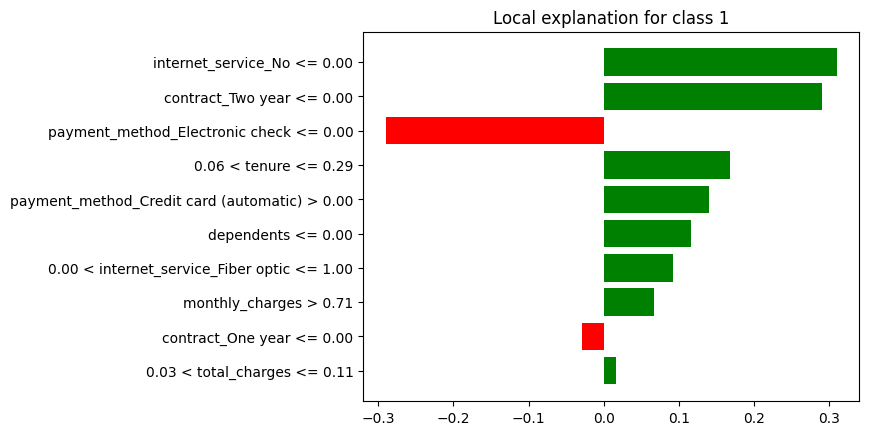

In [80]:
exp.as_pyplot_figure();

Positive values indicate features or conditions that increase the likelihood of the target outcome (e.g., customer churn or a positive classification).
Negative values indicate features or conditions that decrease the likelihood of the target outcome.

('monthly_charges > 0.71', 0.07627570721008793) - Green

Condition: Customers whose monthly charges are greater than 0.71 (likely in normalized values).
Impact: This condition has a positive impact of approximately 0.076 on the model's prediction.

('0.03 < total_charges <= 0.11', 0.021167233295783107) - Green

Condition: Customers whose total charges are between 0.03 and 0.11 (likely in normalized values).
Impact: This condition has a positive impact of approximately 0.021 on the model's prediction.

('contract_One year <= 0.00', -0.01319471574317248) - Red

Condition: Customers who do not have a one-year contract.
Impact: This condition has a negative impact of approximately -0.013 on the model's prediction.

### PARTIAL DEPENDENCE PLOTS

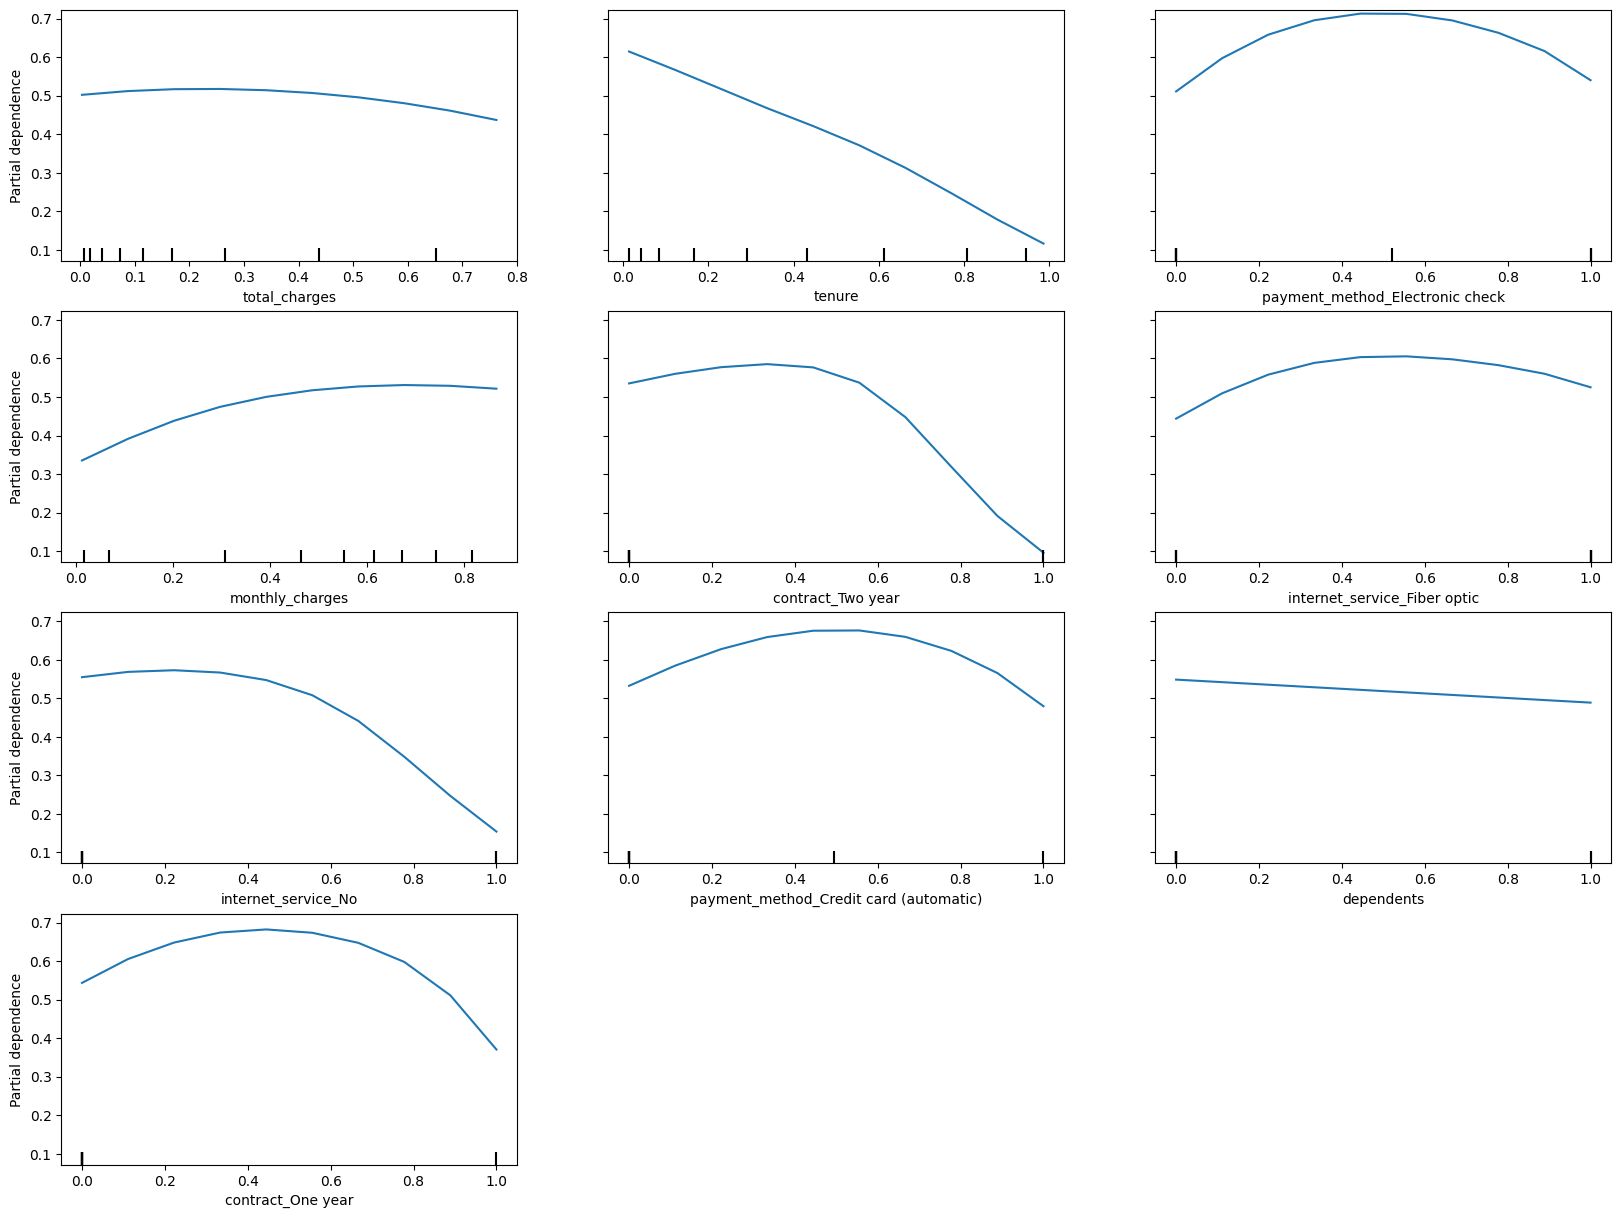

In [81]:
from sklearn.inspection import PartialDependenceDisplay

# Define the features to plot
features = list(range(X_train_selected.shape[1]))  # Create a list of all feature indices

# Set up the figure with a larger size to accommodate all plots and labels
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the Partial Dependence Plots with adjusted layout
display = PartialDependenceDisplay.from_estimator(
    model,           # Your trained model
    X_train_selected,         # Scaled training data
    features,                   # Features to plot
    feature_names=X_train_selected.columns,    # Feature names
    grid_resolution=10,         # Resolution of the grid (more points = more detail)
    ax=ax                       # Use the ax to control layout
)

# Show the plots
plt.show()


#### ANCHORS

In [82]:
from alibi.explainers import AnchorTabular
import pandas as pd
import numpy as np
import os
from sklearn.svm import SVC

# Ensure X_test is a DataFrame with feature names
if not isinstance(X_test_selected, pd.DataFrame):
    X_test_selected = pd.DataFrame(X_test_selected, columns=X_test_selected.columns)  # Use the same feature names from X_train

# Define the predict function for the SVC model
# Load the trained model
model_path = "best_svm_model.pkl"
with open(model_path, "rb") as file:
    model = pickle.load(file)
    
def predict_fn(X):
    if isinstance(X, np.ndarray):  # Convert to DataFrame if it's a NumPy array
        X = pd.DataFrame(X, columns=X_test_selected.columns)
    return model.predict_proba(X)  # This returns the class probabilities

# Method to get the class predictions from your model (for Anchor)
def anchor_predict_fn(X):
    return np.argmax(predict_fn(X), axis=1)  # Get the class with the highest probability

# Initialize the SVC model (replace with your actual trained model)
#model = SVC(probability=True)
#model.fit(X_train_selected, y_train_balanced)

# Initialize the AnchorTabular explainer
anchor_explainer = AnchorTabular(
    predictor=anchor_predict_fn,  # Set the function to get model predictions
    feature_names=X_test_selected.columns.tolist()  # Feature names
)

# Fit the explainer on training data
anchor_explainer.fit(X_test_selected.values)

# Part 1: Anchor and Find If-Then Rules with Current Probability of Class 1
def anchor_analysis_for_sample(sample_index, X_test_selected, explainer):
    sample_data = X_test_selected.iloc[sample_index]
    
    # Get the predicted probabilities for the sample
    original_probabilities = predict_fn(sample_data.values.reshape(1, -1))
    
    # Get the anchor explanation for the sample
    anchor_exp = explainer.explain(sample_data.values)
    
    # Extract features involved in the anchor rule and their conditions (if-then)
    anchor_conditions = anchor_exp.anchor
    
    # Prepare the output table
    print(f"\nAnchor Explanation for Index {sample_index}:")
    print("Feature -> Condition (If-Then Rule)")

    anchor_table = []

    # Add rows for each condition
    for condition in anchor_conditions:
        feature, threshold = condition.split(" > ") if ">" in condition else condition.split(" <= ")
        feature = feature.strip()
        threshold = float(threshold.strip())
        anchor_table.append([feature, f"{condition}"])
    
    anchor_df = pd.DataFrame(anchor_table, columns=["Feature", "Condition"])
    print(anchor_df)

    # Print the original probabilities for class 1
    print(f"\nOriginal Class 1 Probability for Sample Index {sample_index}: {original_probabilities[0][1]}")
    return anchor_df, original_probabilities[0][1]

# Example usage
sample_index = 0  # Change this to the index of the sample you want to analyze
anchor_df, class_1_prob = anchor_analysis_for_sample(sample_index, X_test_selected, anchor_explainer)


Anchor Explanation for Index 0:
Feature -> Condition (If-Then Rule)
             Feature                 Condition
0  contract_Two year  contract_Two year > 0.00

Original Class 1 Probability for Sample Index 0: 0.009584618445325889


In [83]:
# Example usage
sample_index = 100  # Change this to the index of the sample you want to analyze
anchor_df, class_1_prob = anchor_analysis_for_sample(sample_index, X_test_selected, anchor_explainer)


Anchor Explanation for Index 100:
Feature -> Condition (If-Then Rule)
                           Feature                               Condition
0                contract_One year               contract_One year <= 0.00
1  payment_method_Electronic check  payment_method_Electronic check > 0.00
2     internet_service_Fiber optic     internet_service_Fiber optic > 0.00
3                           tenure                          tenure <= 0.39

Original Class 1 Probability for Sample Index 100: 0.9466507428447264


For Sample Index 100, the model's decision is based on the following conditions:

monthly_charges > 0.71 → The customer has relatively high monthly charges.

tenure ≤ 0.39 → The customer has been with the service provider for a short period of time.

internet_service_Fiber optic > 0.00 → The customer is subscribed to a Fiber Optic internet plan.

payment_method_Electronic check > 0.00 → The customer is using Electronic Check as their payment method.

tech_support ≤ 0.00 → The customer does not have technical support services included in their plan.

#### Counterfactual Analysis

In [84]:
def counterfactual_analysis(sample_index, X_test, explainer, target_class_prob_reduction=-0.3, max_alternatives=10, constraints=["tenure", "dependents", "partner"]):
    sample_data = X_test.iloc[sample_index]
    
    # Get the predicted probabilities for the sample
    original_probabilities = predict_fn(sample_data.values.reshape(1, -1))
    print(f"Original Predicted Probabilities for Sample Index {sample_index}: {original_probabilities}")
    
    # Get the anchor explanation for the sample
    anchor_exp = explainer.explain(sample_data.values)
    
    # Extract features involved in the anchor rule and their conditions (if-then)
    anchor_conditions = anchor_exp.anchor
    print("Anchor Explanation:", anchor_exp)
    
    # Prepare the table data and the alternatives list
    table_data = []
    alternatives = []  # List to store the altered sample data
    
    # Generate multiple alternatives by varying features based on the anchor conditions
    for i in range(max_alternatives):
        altered_sample_data = sample_data.copy()
        altered_values = {}  # Store altered feature values
        
        # Apply changes based on anchor conditions
        for condition in anchor_conditions:
            feature, threshold = condition.split(" > ") if ">" in condition else condition.split(" <= ")
            feature = feature.strip()
            threshold = float(threshold.strip())
            
            # Skip the modification of constrained features
            if feature in constraints:
                print(f"Skipping change for constrained feature: {feature}")
                continue  # Skip if the feature is in the constraints list
            
            # Modify the feature value based on the condition to reduce the class 1 probability
            if ">" in condition:
                altered_sample_data[feature] = threshold - 0.1 * (i + 1)  # Vary the change for different alternatives
            elif "<=" in condition:
                altered_sample_data[feature] = threshold + 0.1 * (i + 1)  # Vary the change for different alternatives
            
            altered_values[feature] = altered_sample_data[feature]
        
        # Get the new prediction probabilities for the altered sample
        altered_probabilities = predict_fn(altered_sample_data.values.reshape(1, -1))
        print(f"Altered Predicted Probabilities for Sample Index {sample_index}, Alternative {i+1}: {altered_probabilities}")
        
        # Check if the class 1 probability is reduced as desired
        success_message = ""
        if altered_probabilities[0][1] <= (original_probabilities[0][1] + target_class_prob_reduction):
            success_message = "Successfully reduced Class 1 Probability"
        else:
            success_message = "Did not meet target reduction"
        
        # Prepare the row with original and altered values
        row = {
            "Alternative": i+1,
            "Class 1 Probability (Original)": original_probabilities[0][1],
            "Class 1 Probability (Altered)": altered_probabilities[0][1],
            "Status": success_message
        }
        
        # Add the original feature values
        for feature in altered_sample_data.index:
            row[f"Original {feature}"] = sample_data[feature]
        
        # Add the altered feature values
        for feature, value in altered_values.items():
            row[f"Altered {feature}"] = value
        
        # Append the row to the table data
        table_data.append(row)
        
        # Add altered sample to alternatives list
        alternatives.append(altered_sample_data)
    
    # Convert the table data into a DataFrame for better presentation
    result_df = pd.DataFrame(table_data)
    
    # Print the table with comparison
    print("\nCounterfactual Analysis Table:")
    print(result_df)
    
    return result_df, alternatives


In [85]:
# Perform counterfactual analysis and get the alternatives
counterfactual_result, alternatives = counterfactual_analysis(
    sample_index=100,  # Replace with the desired sample index
    X_test=X_test_selected,  # The test dataset
    explainer=anchor_explainer,  # Anchor explainer initialized above
    target_class_prob_reduction=-0.3,  # Target to reduce class 1 probability by 0.3
    max_alternatives=10,  # Maximum number of alternative scenarios to explore
    constraints=["tenure", "dependents", "partner"]

)

Original Predicted Probabilities for Sample Index 100: [[0.05334926 0.94665074]]
Anchor Explanation: Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (25, 50, 75),
              'threshold': 0.95,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.9.6'}
, data={
  'anchor': ['tenure <= 0.39', 'payment_method_Electronic check > 0.00', 'internet_service_Fiber optic > 0.00', 'contract_Two year <= 0.00'],
  'precision': 

In [86]:
# Apply Constraints and Find Suitable Alternative
def evaluate_alternatives_with_constraints(alternatives, original_sample_data, operational_constraints=["tenure", "dependents", "partner"]):
    # Placeholder for the best alternative
    best_alternative = None
    best_probability = float('inf')  # Initialize with an infinite probability value
    
    # Function to evaluate cost
    def evaluate_cost(altered_sample_data, original_sample_data):
        # Assuming each feature modification costs 0.1 per change
        total_cost = 0
        for feature in altered_sample_data.index:
            if altered_sample_data[feature] != original_sample_data[feature]:
                total_cost -= 0.1  # Cost for each feature change
        return total_cost
    
    # Evaluate each alternative
    for idx, alt in enumerate(alternatives):
        # Check if constrained features (e.g., Tenure, Dependents, Partner) are changed
        if any(alt[feature] != original_sample_data[feature] for feature in operational_constraints):
            print(f"Skipping Alternative {idx+1} due to operational constraints.")
            continue  # Skip this alternative if constrained features are modified
               
        # Get the probabilities for the alternative
        altered_probabilities = predict_fn(alt.values.reshape(1, -1))
        
        # Evaluate if this alternative is better (i.e., reduces Class 1 probability more)
        if altered_probabilities[0][1] < best_probability:
            best_alternative = alt
            best_probability = altered_probabilities[0][1]
            print(f"Alternative {idx+1} is better. New class 1 probability: {best_probability}")
    
    return best_alternative

# Example usage: apply constraints and find the best alternative
best_alternative = evaluate_alternatives_with_constraints(
    alternatives=alternatives,  # The list of generated alternatives
    original_sample_data=X_test_selected.iloc[34],  # The original sample data
    operational_constraints=["tenure", "dependents", "partner"]  # Constrained features
)

# Display the best alternative
print(f"\nBest Alternative after Constraints:\n{best_alternative}")


Skipping Alternative 1 due to operational constraints.
Skipping Alternative 2 due to operational constraints.
Skipping Alternative 3 due to operational constraints.
Skipping Alternative 4 due to operational constraints.
Skipping Alternative 5 due to operational constraints.
Skipping Alternative 6 due to operational constraints.
Skipping Alternative 7 due to operational constraints.
Skipping Alternative 8 due to operational constraints.
Skipping Alternative 9 due to operational constraints.
Skipping Alternative 10 due to operational constraints.

Best Alternative after Constraints:
None


In [87]:
# Part 4: Compare Real Feature Values with Best Alternative
def compare_with_best_alternative(original_sample_data, best_alternative):
    # Ensure both the original sample data and the best alternative are in DataFrame format
    original_data = original_sample_data.copy()
    best_alternative_data = best_alternative.copy()

    # Prepare the comparison table
    comparison_data = []
    
    # Iterate through each feature to compare values
    for feature in original_data.index:
        original_value = original_data[feature]
        best_alternative_value = best_alternative_data[feature]
        
        # Determine if there is a change
        if original_value != best_alternative_value:
            change_status = "Changed"
        else:
            change_status = "No Change"
        
        # Add the comparison row to the data
        comparison_data.append({
            "Feature": feature,
            "Original Value": original_value,
            "Best Alternative Value": best_alternative_value,
            "Change Status": change_status
        })
    
    # Convert the comparison data to a DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Print the comparison table
    print("\nComparison of Real Feature Values with Best Alternative:")
    print(comparison_df)
    
    return comparison_df

# Example usage: compare real feature values with the best alternative
if best_alternative is not None:
    comparison_result = compare_with_best_alternative(
        original_sample_data=X_test.iloc[34],  # Original sample data
        best_alternative=best_alternative  # Best alternative found in Part 3
    )
else:
    print("\nNo valid alternative found.")



No valid alternative found.
